## Import

In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import mobilenet_v3_small
import torch.optim as optim


## Download CIFAR-10 Dataset

In [3]:
# Check if CIFAR-10 dataset is downloaded

transform = transforms.Compose([
    # CIFAR-10 images are 32x32; MobileNet needs 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=4)

## Preview dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802876..1.3446536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.7410581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802876..1.4262533].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4488223..1.5192983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7387124..1.9959002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.989473

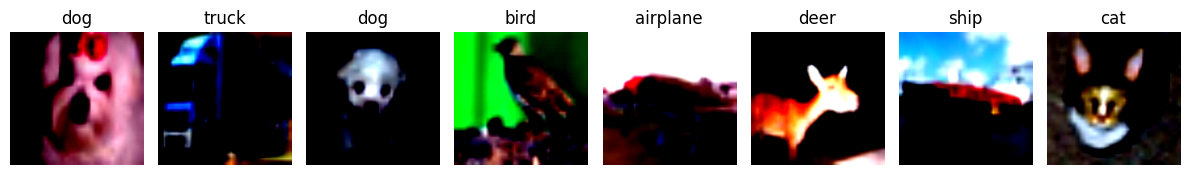

In [4]:

# Class labels for CIFAR-10
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = train_dataset.classes

# Grab a batch
images, labels = next(iter(train_loader))

# Convert from tensors to numpy for plotting


def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')


# Plot images in a row
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()


## Load trained ResNet50 model in

In [13]:
from ResNet50WithHyperperameter import ResNet50

# Load teacher architecture
teacher_model = ResNet50(num_classes=10)

# Load the pre-trained weights
teacher_path = "ResNet50_Teacher.pth"
teacher_model.load_state_dict(torch.load(teacher_path, map_location='cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model.to(device)

# Set to evaluation mode and freeze parameters
print(device)
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="Evaluating teacher model"):
        images, labels = images.to(device), labels.to(device)
        outputs = teacher_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


cpu


Evaluating teacher model:   0%|          | 0/782 [00:17<?, ?it/s]


KeyboardInterrupt: 

## Load student model

In [ ]:
from Simple_CNN_V1_model import SimpleCNN
# Load student architecture
student_model = SimpleCNN(num_classes=10)
# Move to device
student_model.to(device)
# Set to training mode
student_model.train()
# Define loss function and optimizer
optimizer = optim.Adam(student_model.parameters(), lr=0.001)


## Distillation loss

In [ ]:


def distillation_loss(student_logits, teacher_logits, targets, T=2.0, alpha=0.5):
    """
    student_logits: output from student network (before softmax)
    teacher_logits: output from teacher network (before softmax)
    targets: ground truth labels
    T: temperature for softening
    alpha: weight between soft and hard losses
    """
    # Hard loss
    hard_loss = F.cross_entropy(student_logits, targets)

    # Soft loss (KL divergence with softened logits)
    soft_teacher = F.log_softmax(teacher_logits / T, dim=1)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (T * T)

    # Combined loss
    return alpha * hard_loss + (1 - alpha) * soft_loss

## Training loop

In [ ]:
# Initialize student model

def train_student(student_model, teacher_model, train_loader, optimizer, device, epochs=10, T=2.0, alpha=0.5):
    student_model.train()
    teacher_model.eval()

    for epoch in range(epochs):
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass through both models
            student_logits = student_model(images)
            with torch.no_grad():
                teacher_logits = teacher_model(images)

            # Compute distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels, T=T, alpha=alpha)

            # Backprop and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()   

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
